# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 988us/sample - loss: 253.1114 - y1_output_loss: 120.2202 - y2_output_loss: 130.7899 - y1_output_root_mean_squared_error: 11.0147 - y2_output_root_mean_squared_error: 11.4798 - val_loss: 126.4049 - val_y1_output_loss: 31.4794 - val_y2_output_loss: 90.5151 - val_y1_output_root_mean_squared_error: 5.7099 - val_y2_output_root_mean_squared_error: 9.6851
Epoch 2/500
614/614 [==============================] - 0s 184us/sample - loss: 30.2381 - y1_output_loss: 12.2614 - y2_output_loss: 17.8446 - y1_output_root_mean_squared_error: 3.5115 - y2_output_root_mean_squared_error: 4.2317 - val_loss: 30.6817 - val_y1_output_loss: 11.8646 - val_y2_output_loss: 17.9023 - val_y1_output_root_mean_squared_error: 3.4990 - val_y2_output_root_mean_squared_error: 4.2940
Epoch 3/500
614/614 [==============================] - 0s 149us/sample - loss: 24.1009 - y1_output_loss: 9.8268 - y2_output_loss: 14.2152 - y1

614/614 [==============================] - 0s 147us/sample - loss: 8.0310 - y1_output_loss: 2.7848 - y2_output_loss: 5.1747 - y1_output_root_mean_squared_error: 1.6761 - y2_output_root_mean_squared_error: 2.2851 - val_loss: 7.0838 - val_y1_output_loss: 1.8220 - val_y2_output_loss: 5.1011 - val_y1_output_root_mean_squared_error: 1.3500 - val_y2_output_root_mean_squared_error: 2.2938
Epoch 42/500
614/614 [==============================] - 0s 149us/sample - loss: 7.1210 - y1_output_loss: 2.3512 - y2_output_loss: 4.7572 - y1_output_root_mean_squared_error: 1.5398 - y2_output_root_mean_squared_error: 2.1795 - val_loss: 6.1422 - val_y1_output_loss: 1.7270 - val_y2_output_loss: 4.2369 - val_y1_output_root_mean_squared_error: 1.3288 - val_y2_output_root_mean_squared_error: 2.0920
Epoch 43/500
614/614 [==============================] - 0s 144us/sample - loss: 8.5885 - y1_output_loss: 2.8586 - y2_output_loss: 5.7265 - y1_output_root_mean_squared_error: 1.6961 - y2_output_root_mean_squared_error:

Epoch 62/500
614/614 [==============================] - 0s 141us/sample - loss: 4.9394 - y1_output_loss: 1.3402 - y2_output_loss: 3.5596 - y1_output_root_mean_squared_error: 1.1631 - y2_output_root_mean_squared_error: 1.8938 - val_loss: 4.5482 - val_y1_output_loss: 1.0379 - val_y2_output_loss: 3.3655 - val_y1_output_root_mean_squared_error: 1.0282 - val_y2_output_root_mean_squared_error: 1.8684
Epoch 63/500
614/614 [==============================] - 0s 143us/sample - loss: 4.9822 - y1_output_loss: 1.3741 - y2_output_loss: 3.6442 - y1_output_root_mean_squared_error: 1.1756 - y2_output_root_mean_squared_error: 1.8974 - val_loss: 8.3922 - val_y1_output_loss: 2.1924 - val_y2_output_loss: 5.9171 - val_y1_output_root_mean_squared_error: 1.5021 - val_y2_output_root_mean_squared_error: 2.4771
Epoch 64/500
614/614 [==============================] - 0s 141us/sample - loss: 5.9164 - y1_output_loss: 1.6717 - y2_output_loss: 4.2452 - y1_output_root_mean_squared_error: 1.2939 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 141us/sample - loss: 4.4618 - y1_output_loss: 1.1006 - y2_output_loss: 3.3252 - y1_output_root_mean_squared_error: 1.0539 - y2_output_root_mean_squared_error: 1.8306 - val_loss: 4.3991 - val_y1_output_loss: 0.7410 - val_y2_output_loss: 3.5308 - val_y1_output_root_mean_squared_error: 0.8588 - val_y2_output_root_mean_squared_error: 1.9135
Epoch 84/500
614/614 [==============================] - 0s 144us/sample - loss: 8.2694 - y1_output_loss: 2.8568 - y2_output_loss: 5.6026 - y1_output_root_mean_squared_error: 1.6665 - y2_output_root_mean_squared_error: 2.3436 - val_loss: 12.4873 - val_y1_output_loss: 5.0388 - val_y2_output_loss: 8.4223 - val_y1_output_root_mean_squared_error: 2.0900 - val_y2_output_root_mean_squared_error: 2.8494
Epoch 85/500
614/614 [==============================] - 0s 140us/sample - loss: 4.7863 - y1_output_loss: 1.3826 - y2_output_loss: 3.3613 - y1_output_root_mean_squared_error: 1.1807 - y2_output_root_mean_

Epoch 104/500
614/614 [==============================] - 0s 148us/sample - loss: 2.9265 - y1_output_loss: 0.6056 - y2_output_loss: 2.3259 - y1_output_root_mean_squared_error: 0.7794 - y2_output_root_mean_squared_error: 1.5228 - val_loss: 4.2300 - val_y1_output_loss: 0.5585 - val_y2_output_loss: 3.5418 - val_y1_output_root_mean_squared_error: 0.7424 - val_y2_output_root_mean_squared_error: 1.9180
Epoch 105/500
614/614 [==============================] - 0s 146us/sample - loss: 3.4991 - y1_output_loss: 0.7526 - y2_output_loss: 2.7822 - y1_output_root_mean_squared_error: 0.8628 - y2_output_root_mean_squared_error: 1.6597 - val_loss: 9.0814 - val_y1_output_loss: 2.5302 - val_y2_output_loss: 6.3681 - val_y1_output_root_mean_squared_error: 1.5980 - val_y2_output_root_mean_squared_error: 2.5549
Epoch 106/500
614/614 [==============================] - 0s 151us/sample - loss: 2.7943 - y1_output_loss: 0.5769 - y2_output_loss: 2.2205 - y1_output_root_mean_squared_error: 0.7600 - y2_output_root_mea

Epoch 145/500
614/614 [==============================] - 0s 148us/sample - loss: 1.5744 - y1_output_loss: 0.3648 - y2_output_loss: 1.2177 - y1_output_root_mean_squared_error: 0.6011 - y2_output_root_mean_squared_error: 1.1014 - val_loss: 6.4186 - val_y1_output_loss: 0.8337 - val_y2_output_loss: 5.3839 - val_y1_output_root_mean_squared_error: 0.9180 - val_y2_output_root_mean_squared_error: 2.3613
Epoch 146/500
614/614 [==============================] - 0s 147us/sample - loss: 2.1952 - y1_output_loss: 0.4457 - y2_output_loss: 1.8570 - y1_output_root_mean_squared_error: 0.6674 - y2_output_root_mean_squared_error: 1.3228 - val_loss: 7.4892 - val_y1_output_loss: 1.6348 - val_y2_output_loss: 6.2042 - val_y1_output_root_mean_squared_error: 1.2038 - val_y2_output_root_mean_squared_error: 2.4576
Epoch 147/500
614/614 [==============================] - 0s 143us/sample - loss: 2.4313 - y1_output_loss: 0.5598 - y2_output_loss: 1.8522 - y1_output_root_mean_squared_error: 0.7512 - y2_output_root_mea

Epoch 186/500
614/614 [==============================] - 0s 146us/sample - loss: 1.7365 - y1_output_loss: 0.3170 - y2_output_loss: 1.4166 - y1_output_root_mean_squared_error: 0.5644 - y2_output_root_mean_squared_error: 1.1908 - val_loss: 1.9861 - val_y1_output_loss: 0.3516 - val_y2_output_loss: 1.5921 - val_y1_output_root_mean_squared_error: 0.5769 - val_y2_output_root_mean_squared_error: 1.2858
Epoch 187/500
614/614 [==============================] - 0s 143us/sample - loss: 1.1660 - y1_output_loss: 0.2451 - y2_output_loss: 0.9185 - y1_output_root_mean_squared_error: 0.4965 - y2_output_root_mean_squared_error: 0.9589 - val_loss: 1.7866 - val_y1_output_loss: 0.3773 - val_y2_output_loss: 1.3828 - val_y1_output_root_mean_squared_error: 0.5959 - val_y2_output_root_mean_squared_error: 1.1965
Epoch 188/500
614/614 [==============================] - 0s 146us/sample - loss: 1.3389 - y1_output_loss: 0.3085 - y2_output_loss: 1.0448 - y1_output_root_mean_squared_error: 0.5492 - y2_output_root_mea

Epoch 227/500
614/614 [==============================] - 0s 145us/sample - loss: 1.0502 - y1_output_loss: 0.2272 - y2_output_loss: 0.8328 - y1_output_root_mean_squared_error: 0.4773 - y2_output_root_mean_squared_error: 0.9069 - val_loss: 2.4290 - val_y1_output_loss: 0.4751 - val_y2_output_loss: 1.9211 - val_y1_output_root_mean_squared_error: 0.6685 - val_y2_output_root_mean_squared_error: 1.4079
Epoch 228/500
614/614 [==============================] - 0s 153us/sample - loss: 1.5116 - y1_output_loss: 0.3033 - y2_output_loss: 1.2015 - y1_output_root_mean_squared_error: 0.5521 - y2_output_root_mean_squared_error: 1.0985 - val_loss: 1.6670 - val_y1_output_loss: 0.3628 - val_y2_output_loss: 1.2796 - val_y1_output_root_mean_squared_error: 0.5838 - val_y2_output_root_mean_squared_error: 1.1516
Epoch 229/500
614/614 [==============================] - 0s 158us/sample - loss: 0.9224 - y1_output_loss: 0.1935 - y2_output_loss: 0.7393 - y1_output_root_mean_squared_error: 0.4391 - y2_output_root_mea

Epoch 268/500
614/614 [==============================] - 0s 145us/sample - loss: 0.9230 - y1_output_loss: 0.2073 - y2_output_loss: 0.7084 - y1_output_root_mean_squared_error: 0.4572 - y2_output_root_mean_squared_error: 0.8450 - val_loss: 1.3968 - val_y1_output_loss: 0.3330 - val_y2_output_loss: 1.0534 - val_y1_output_root_mean_squared_error: 0.5530 - val_y2_output_root_mean_squared_error: 1.0445
Epoch 269/500
614/614 [==============================] - 0s 145us/sample - loss: 2.1470 - y1_output_loss: 0.6035 - y2_output_loss: 1.5308 - y1_output_root_mean_squared_error: 0.7799 - y2_output_root_mean_squared_error: 1.2405 - val_loss: 1.7882 - val_y1_output_loss: 0.3974 - val_y2_output_loss: 1.3946 - val_y1_output_root_mean_squared_error: 0.5914 - val_y2_output_root_mean_squared_error: 1.1993
Epoch 270/500
614/614 [==============================] - 0s 142us/sample - loss: 1.2951 - y1_output_loss: 0.2391 - y2_output_loss: 1.0487 - y1_output_root_mean_squared_error: 0.4885 - y2_output_root_mea

Epoch 309/500
614/614 [==============================] - 0s 142us/sample - loss: 0.7238 - y1_output_loss: 0.1599 - y2_output_loss: 0.5666 - y1_output_root_mean_squared_error: 0.3957 - y2_output_root_mean_squared_error: 0.7531 - val_loss: 1.4038 - val_y1_output_loss: 0.4006 - val_y2_output_loss: 0.9909 - val_y1_output_root_mean_squared_error: 0.6121 - val_y2_output_root_mean_squared_error: 1.0145
Epoch 310/500
614/614 [==============================] - 0s 149us/sample - loss: 0.9952 - y1_output_loss: 0.2322 - y2_output_loss: 0.7584 - y1_output_root_mean_squared_error: 0.4828 - y2_output_root_mean_squared_error: 0.8730 - val_loss: 1.6662 - val_y1_output_loss: 0.3868 - val_y2_output_loss: 1.2842 - val_y1_output_root_mean_squared_error: 0.5850 - val_y2_output_root_mean_squared_error: 1.1506
Epoch 311/500
614/614 [==============================] - 0s 148us/sample - loss: 0.9237 - y1_output_loss: 0.1995 - y2_output_loss: 0.7249 - y1_output_root_mean_squared_error: 0.4440 - y2_output_root_mea

Epoch 350/500
614/614 [==============================] - 0s 146us/sample - loss: 0.8377 - y1_output_loss: 0.1833 - y2_output_loss: 0.6489 - y1_output_root_mean_squared_error: 0.4278 - y2_output_root_mean_squared_error: 0.8091 - val_loss: 1.2338 - val_y1_output_loss: 0.3116 - val_y2_output_loss: 0.9477 - val_y1_output_root_mean_squared_error: 0.5104 - val_y2_output_root_mean_squared_error: 0.9865
Epoch 351/500
614/614 [==============================] - 0s 148us/sample - loss: 0.7573 - y1_output_loss: 0.1674 - y2_output_loss: 0.5948 - y1_output_root_mean_squared_error: 0.4103 - y2_output_root_mean_squared_error: 0.7674 - val_loss: 1.6912 - val_y1_output_loss: 0.3890 - val_y2_output_loss: 1.2938 - val_y1_output_root_mean_squared_error: 0.5945 - val_y2_output_root_mean_squared_error: 1.1566
Epoch 352/500
614/614 [==============================] - 0s 144us/sample - loss: 0.7910 - y1_output_loss: 0.1796 - y2_output_loss: 0.6130 - y1_output_root_mean_squared_error: 0.4242 - y2_output_root_mea

Epoch 391/500
614/614 [==============================] - 0s 144us/sample - loss: 0.5515 - y1_output_loss: 0.1340 - y2_output_loss: 0.4137 - y1_output_root_mean_squared_error: 0.3668 - y2_output_root_mean_squared_error: 0.6457 - val_loss: 1.3905 - val_y1_output_loss: 0.3624 - val_y2_output_loss: 1.0193 - val_y1_output_root_mean_squared_error: 0.5779 - val_y2_output_root_mean_squared_error: 1.0279
Epoch 392/500
614/614 [==============================] - 0s 150us/sample - loss: 0.7627 - y1_output_loss: 0.1606 - y2_output_loss: 0.6003 - y1_output_root_mean_squared_error: 0.3997 - y2_output_root_mean_squared_error: 0.7765 - val_loss: 1.2752 - val_y1_output_loss: 0.3482 - val_y2_output_loss: 0.9176 - val_y1_output_root_mean_squared_error: 0.5734 - val_y2_output_root_mean_squared_error: 0.9728
Epoch 393/500
614/614 [==============================] - 0s 149us/sample - loss: 0.6646 - y1_output_loss: 0.1669 - y2_output_loss: 0.4927 - y1_output_root_mean_squared_error: 0.4095 - y2_output_root_mea

Epoch 432/500
614/614 [==============================] - 0s 152us/sample - loss: 0.4524 - y1_output_loss: 0.1486 - y2_output_loss: 0.3020 - y1_output_root_mean_squared_error: 0.3850 - y2_output_root_mean_squared_error: 0.5515 - val_loss: 1.3299 - val_y1_output_loss: 0.3045 - val_y2_output_loss: 1.0333 - val_y1_output_root_mean_squared_error: 0.5082 - val_y2_output_root_mean_squared_error: 1.0352
Epoch 433/500
614/614 [==============================] - 0s 142us/sample - loss: 0.6070 - y1_output_loss: 0.1863 - y2_output_loss: 0.4203 - y1_output_root_mean_squared_error: 0.4331 - y2_output_root_mean_squared_error: 0.6476 - val_loss: 2.2832 - val_y1_output_loss: 0.4537 - val_y2_output_loss: 1.7913 - val_y1_output_root_mean_squared_error: 0.6538 - val_y2_output_root_mean_squared_error: 1.3623
Epoch 434/500
614/614 [==============================] - 0s 144us/sample - loss: 0.5946 - y1_output_loss: 0.1687 - y2_output_loss: 0.4245 - y1_output_root_mean_squared_error: 0.4075 - y2_output_root_mea

Epoch 473/500
614/614 [==============================] - 0s 145us/sample - loss: 0.4186 - y1_output_loss: 0.1180 - y2_output_loss: 0.2980 - y1_output_root_mean_squared_error: 0.3449 - y2_output_root_mean_squared_error: 0.5474 - val_loss: 1.2177 - val_y1_output_loss: 0.3283 - val_y2_output_loss: 0.8994 - val_y1_output_root_mean_squared_error: 0.5354 - val_y2_output_root_mean_squared_error: 0.9649
Epoch 474/500
614/614 [==============================] - 0s 143us/sample - loss: 0.3771 - y1_output_loss: 0.1085 - y2_output_loss: 0.2741 - y1_output_root_mean_squared_error: 0.3277 - y2_output_root_mean_squared_error: 0.5193 - val_loss: 1.1703 - val_y1_output_loss: 0.3379 - val_y2_output_loss: 0.8270 - val_y1_output_root_mean_squared_error: 0.5603 - val_y2_output_root_mean_squared_error: 0.9254
Epoch 475/500
614/614 [==============================] - 0s 146us/sample - loss: 0.4335 - y1_output_loss: 0.1301 - y2_output_loss: 0.3061 - y1_output_root_mean_squared_error: 0.3602 - y2_output_root_mea

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 48us/sample - loss: 1.1335 - y1_output_loss: 0.2527 - y2_output_loss: 0.8800 - y1_output_root_mean_squared_error: 0.4982 - y2_output_root_mean_squared_error: 0.9409
Loss = 1.1334783380681819, Y1_loss = 0.2527109980583191, Y1_mse = 0.49818155169487, Y2_loss = 0.8799765706062317, Y2_mse = 0.9409003853797913


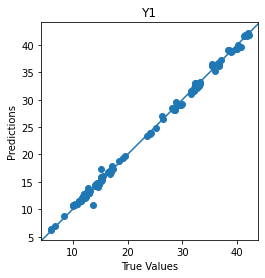

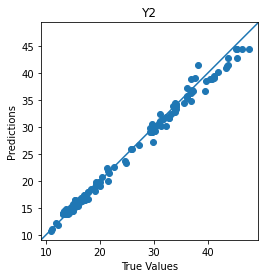

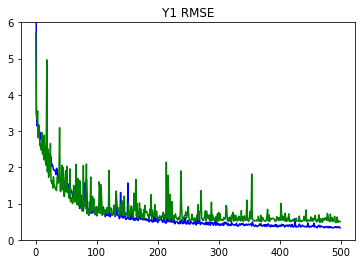

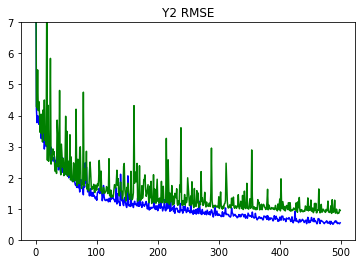

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)